# E-Commerce Delivery Project

In [426]:
# Import Libraries:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, KFold, StratifiedKFold
from sklearn.decomposition import PCA
from scipy import stats

from sklearn.compose import ColumnTransformer
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.pipeline import Pipeline
from sklearn.utils.validation import check_is_fitted

from sklearn.decomposition import PCA
from statsmodels.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC, SVR
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.calibration import CalibratedClassifierCV

from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score

In [5]:
df = pd.read_csv(r"G:\Data Science Eduminds\Projects\GitHub\Mini-Projects\E-Commerce Delivery\E_Commerce.csv")
df.head(5)

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
0,1,D,Flight,4,2,177,3,low,F,44,1233,1
1,2,F,Flight,4,5,216,2,low,M,59,3088,1
2,3,A,Flight,2,2,183,4,low,M,48,3374,1
3,4,B,Flight,3,3,176,4,medium,M,10,1177,1
4,5,C,Flight,2,2,184,3,medium,F,46,2484,1


In [11]:
df.drop('ID', axis=1, inplace=True)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10999 entries, 0 to 10998
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Warehouse_block      10999 non-null  object
 1   Mode_of_Shipment     10999 non-null  object
 2   Customer_care_calls  10999 non-null  int64 
 3   Customer_rating      10999 non-null  int64 
 4   Cost_of_the_Product  10999 non-null  int64 
 5   Prior_purchases      10999 non-null  int64 
 6   Product_importance   10999 non-null  object
 7   Gender               10999 non-null  object
 8   Discount_offered     10999 non-null  int64 
 9   Weight_in_gms        10999 non-null  int64 
 10  Reached.on.Time_Y.N  10999 non-null  int64 
dtypes: int64(7), object(4)
memory usage: 945.4+ KB


In [13]:
df.describe()

,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
count,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000
mean,4.054459,2.990545,210.196836,3.567597,13.373216,3634.016729,0.596691
std,1.141490,1.413603,48.063272,1.522860,16.205527,1635.377251,0.490584
min,2.000000,1.000000,96.000000,2.000000,1.000000,1001.000000,0.000000
25%,3.000000,2.000000,169.000000,3.000000,4.000000,1839.500000,0.000000
50%,4.000000,3.000000,214.000000,3.000000,7.000000,4149.000000,1.000000
75%,5.000000,4.000000,251.000000,4.000000,10.000000,5050.000000,1.000000
max,7.000000,5.000000,310.000000,10.000000,65.000000,7846.000000,1.000000


In [16]:
df.duplicated().sum()

0

In [14]:
df.corr(numeric_only=True)

,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
Customer_care_calls,1.000000,0.012209,0.323182,0.180771,-0.130750,-0.276615,-0.067126
Customer_rating,0.012209,1.000000,0.009270,0.013179,-0.003124,-0.001897,0.013119
Cost_of_the_Product,0.323182,0.009270,1.000000,0.123676,-0.138312,-0.132604,-0.073587
Prior_purchases,0.180771,0.013179,0.123676,1.000000,-0.082769,-0.168213,-0.055515
Discount_offered,-0.130750,-0.003124,-0.138312,-0.082769,1.000000,-0.376067,0.397108
Weight_in_gms,-0.276615,-0.001897,-0.132604,-0.168213,-0.376067,1.000000,-0.268793
Reached.on.Time_Y.N,-0.067126,0.013119,-0.073587,-0.055515,0.397108,-0.268793,1.000000


In [19]:
# Check unique values per feature:
unique_values = pd.DataFrame(columns=['Features', 'Distinct Values', 'Distinct Value Count'])
# unique_values['Features'] = df.columns
for col in df.columns:
    row = col, df[col].unique(), df[col].nunique()
    unique_values.loc[len(unique_values)] = row

unique_values

,Features,Distinct Values,Distinct Value Count
0,Warehouse_block,"[D, F, A, B, C]",5
1,Mode_of_Shipment,"[Flight, Ship, Road]",3
2,Customer_care_calls,"[4, 2, 3, 5, 6, 7]",6
3,Customer_rating,"[2, 5, 3, 1, 4]",5
4,Cost_of_the_Product,"[177, 216, 183, 176, 184, 162, 250, 233, 150, ...",215
5,Prior_purchases,"[3, 2, 4, 6, 5, 7, 10, 8]",8
6,Product_importance,"[low, medium, high]",3
7,Gender,"[F, M]",2
8,Discount_offered,"[44, 59, 48, 10, 46, 12, 3, 11, 29, 32, 1, 43,...",65
9,Weight_in_gms,"[1233, 3088, 3374, 1177, 2484, 1417, 2371, 280...",4034


- We are only interested in 'Warehouse_block', 'Mode_of_Shipment', 'Product_importance', and 'Gender'  
- We need to encode them before proceeding further with model building.

In [21]:
# Data Visualization:

<Figure size 640x480 with 0 Axes>

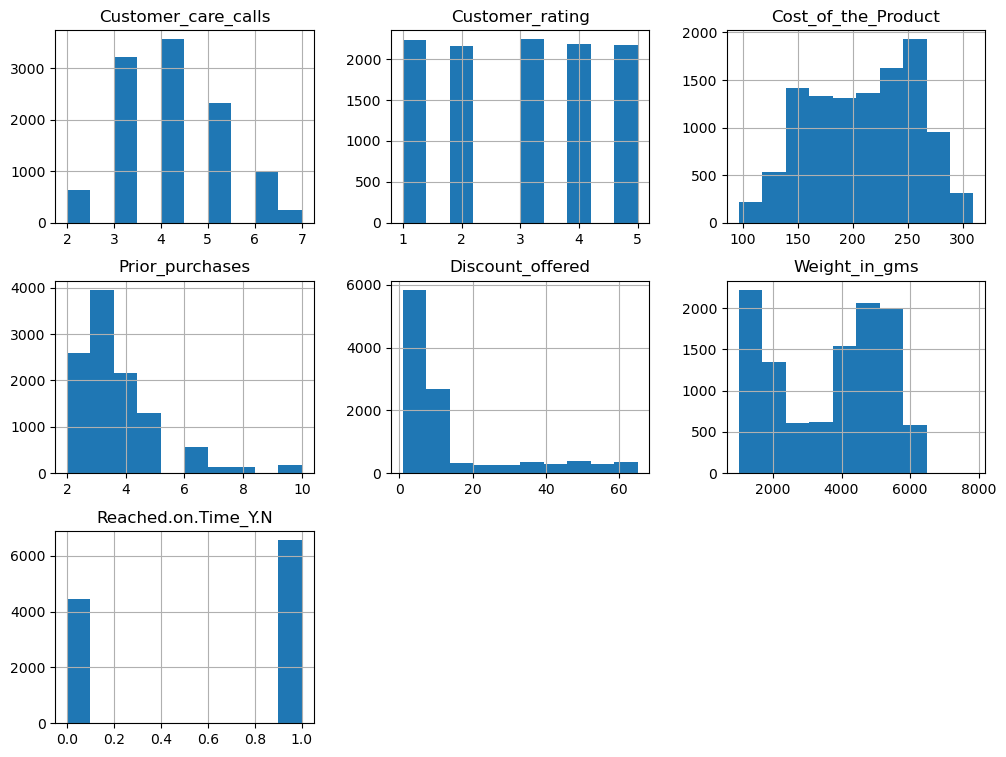

In [27]:
# We'll use hist to check numeric feature's distribution:

df.hist(figsize=(12,9))
plt.show()

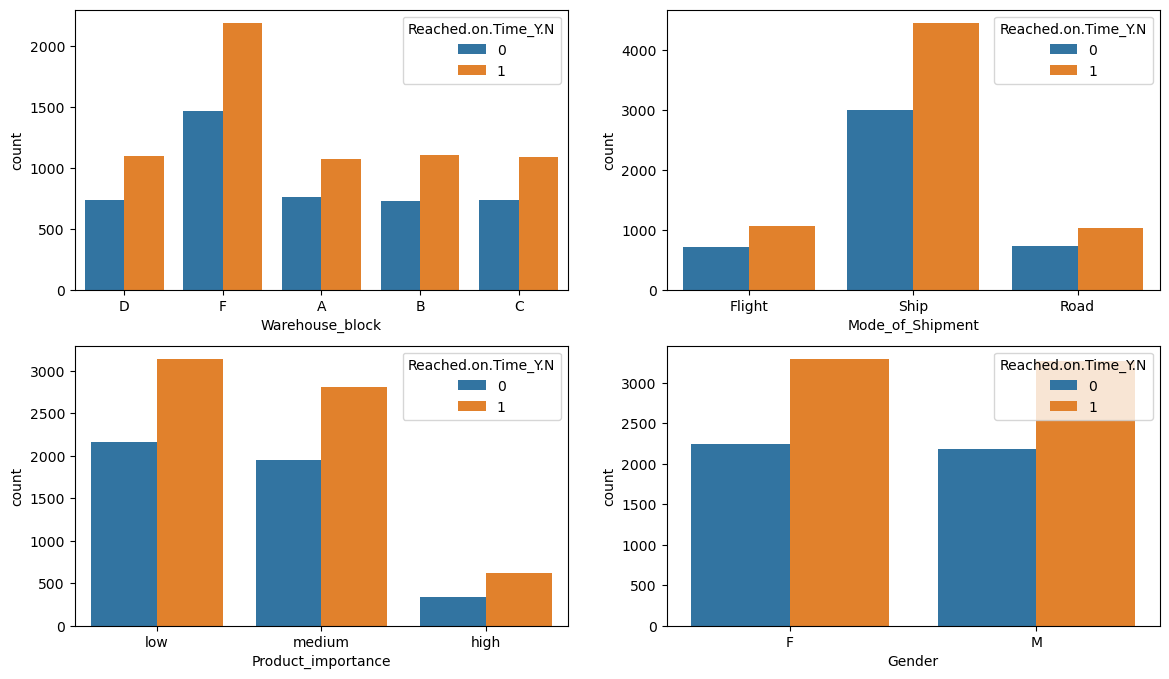

In [105]:
# for categorical features we'll use count plot:
fig, axes = plt.subplots(2,2, figsize=(14,8))
axes = axes.reshape(-1)
i=0
for col in df.select_dtypes(object).columns:
    sns.countplot(data=df, x=col, hue=df['Reached.on.Time_Y.N'], ax=axes[i])
    i =i+1
plt.show()

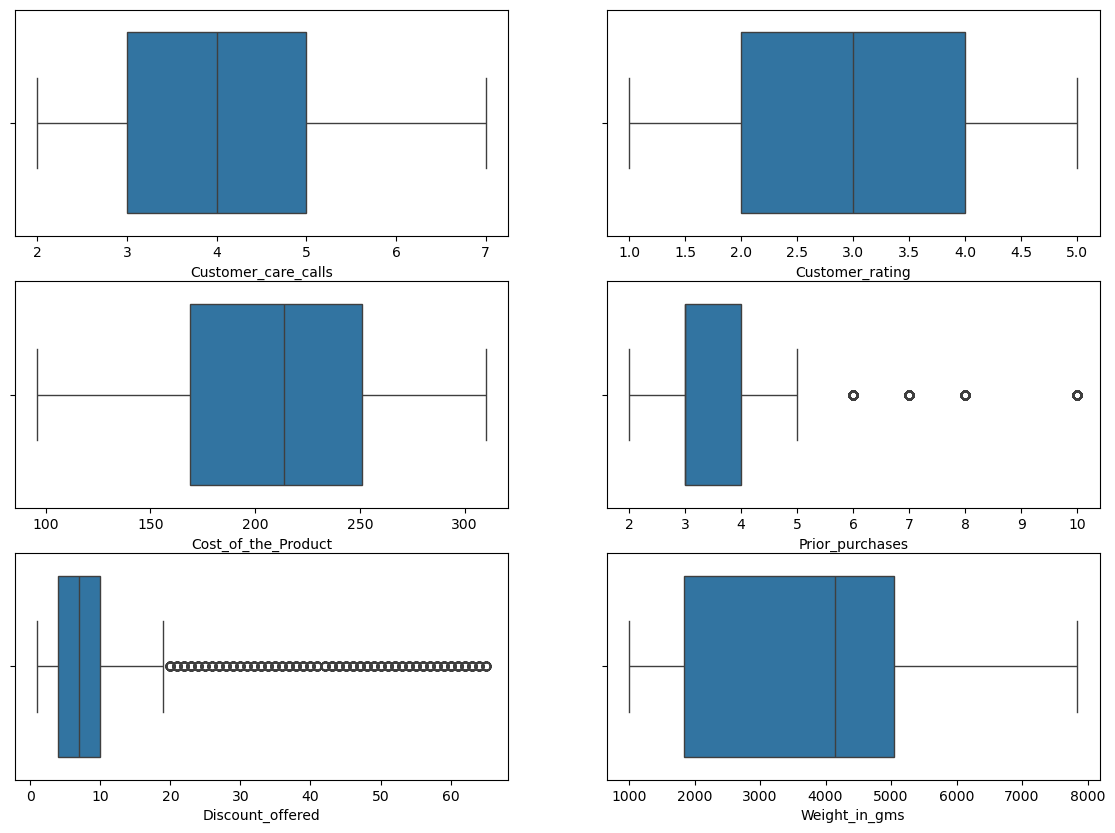

In [117]:
# for categorical features we'll use box plot to see/confirm outliers found in describe function:
fig, axes = plt.subplots(3,2, figsize=(14,10))
axes = axes.reshape(-1)
i=0
for col in df.drop('Reached.on.Time_Y.N', axis=1).select_dtypes(np.number).columns:
    sns.boxplot(data=df, x=col, ax=axes[i])
    i =i+1
plt.show()

- For Prior_purchases and Discount_offered we need to handle outliers using IQR or Z-score:

In [193]:
# Check number of outliers will be removed in IQR vs Z-score:
num_df = df.select_dtypes(np.number)
Q1 = num_df.quantile(q=0.25, numeric_only=True)
Q3 = num_df.quantile(q=0.75, numeric_only=True)
IQR = Q3-Q1
lower_bound = Q1 - IQR*1.5 
upper_bound = Q3 + IQR*1.5
outliers = num_df[(num_df >= lower_bound) & (num_df <= upper_bound)]
outliers.isnull().sum()

Customer_care_calls       0
Customer_rating           0
Cost_of_the_Product       0
Prior_purchases        1003
Discount_offered       2209
Weight_in_gms             0
Reached.on.Time_Y.N       0
dtype: int64

- We can see that using IQR we may remove min 2209 or max 3212 samples.

In [285]:
outliers = num_df[(stats.zscore(num_df) < 3) & (stats.zscore(num_df) > -3)]
outliers.isnull().sum()

Customer_care_calls      0
Customer_rating          0
Cost_of_the_Product      0
Prior_purchases        178
Discount_offered       181
Weight_in_gms            0
Reached.on.Time_Y.N      0
dtype: int64

- We can see that using Z-Score we may remove min 181 or max 359 samples.
- So, we'll use Z-Score to handle outliers as it will maintain large sample size.

In [286]:
outliers

,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
0,4,2,177,3.0,44.0,1233,1
1,4,5,216,2.0,59.0,3088,1
2,2,2,183,4.0,48.0,3374,1
3,3,3,176,4.0,10.0,1177,1
4,2,2,184,3.0,46.0,2484,1
...,...,...,...,...,...,...,...
10994,4,1,252,5.0,1.0,1538,1
10995,4,1,232,5.0,6.0,1247,0
10996,5,4,242,5.0,4.0,1155,0
10997,5,2,223,6.0,2.0,1210,0


In [317]:
# Split the df into X and y and then into Train and Test set:

X = df.drop('Reached.on.Time_Y.N', axis=1)
y = df['Reached.on.Time_Y.N']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

In [318]:
# Handle outliers outside the Pipeline as it would be in training phase only.
num_df = X_train.select_dtypes(np.number)
outliers_index = num_df[(stats.zscore(num_df) < 3) & (stats.zscore(num_df) > -3)].dropna().index
X_train = X_train.loc[outliers_index]
y_train = y_train.loc[outliers_index]

In [319]:
# Confirm the shape of both X_train and y_train:
X_train.shape, y_train.shape

((7979, 10), (7979,))

In [320]:
# Check the class imbalance:
y.value_counts()

Reached.on.Time_Y.N
1    6563
0    4436
Name: count, dtype: int64

- Class imbalance is not that big so no need to overcomplicate the model.

### Action plan for Data Pipeline and model building:
    1. Create Custom Transformer for each of below transformation:
       - Encoding cat features
       - Scale num features
    2. Create Sample Pipeline and fit it with sample estimator.
    3. Create reusable pipeline for further use.
    4. Train, test, and then evaluate multiple models.
    5. Fine tune hyperparameters for best model.
    6. Pickle the tunned model for deployment.

In [480]:
class create_features(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.num_cols = None
        self.cat_cols = None

    def fit(self, X, y=None):
        self.num_cols = X.select_dtypes(np.number).columns
        self.cat_cols = X.select_dtypes(object).columns
        # print(f'num_cols in create_features :{self.num_cols}')
        # print(f'cat_cols in create_features :{self.cat_cols}')
        self.fitted_ = True
        return self

    def transform(self, X):
        check_is_fitted(self, 'fitted_')
        self.cat_cols = X.select_dtypes(object).columns
        X_new = X.copy()
        
        X_new['calls_per_rate'] = X['Customer_care_calls'] / X['Customer_rating']
        X_new['discounted_price'] = X['Cost_of_the_Product'] - X['Discount_offered']
        X_new['earlier_purchase'] = X['Prior_purchases'].apply(lambda x: 0 if x == 0 else 1)
        X_new['weight_per_rate'] = X['Weight_in_gms'] / X['Customer_rating']
        
        print('\n---------------------------------------------------------------------------------------------')
        # print('\n\n create_features - head of X_new: \n',X_new.head(5))
        print(f'\tFeature Engineering:\t\t Total Features: {X_new.shape[1]}\t Total Samples: {X_new.shape[0]}')
        # print('\n---------------------------------------------------------------------------------------')
        return X_new

##############################################################################################################

from sklearn.preprocessing import OrdinalEncoder
class ord_encoder(TransformerMixin, BaseEstimator):
    def __init__(self):
        self.encoder = OrdinalEncoder(categories=[['low', 'medium', 'high']], handle_unknown='use_encoded_value', unknown_value=-1)
        self.cols = None
        self.en_cols = None
        self.final_df = None
    def fit(self, X, y=None):
        self.cols = X.columns.to_list()
        self.encoder.fit(X)
        self.en_cols = self.encoder.get_feature_names_out()
        # print('In encoder fit: ', self.en_cols)
        self.fitted_ = True
        return self

    def transform(self, X, y=None):
        check_is_fitted(self, 'fitted_')
        X_en = self.encoder.transform(X)
        X_en_df = pd.DataFrame(X_en, columns=self.en_cols, index=X.index)
        print(f'\tOrdinal Encoder:\t\t Total Features: {X_en_df.shape[1]}\t Total Samples: {X_en_df.shape[0]}')
        self.final_df = X_en_df
        return X_en_df

    def get_feature_names_out(self, input_features=None):
        # Return the feature names after transformation
        if hasattr(self.final_df, 'columns'):
            return self.final_df.columns
        else:
            # return [f"feature_{i}" for i in range(self.final_df.shape[1])]
            temp = [x for x in self.cols if x not in self.en_cols]
            temp.extend(self.en_cols)
            return temp

##############################################################################################################

class encoder(TransformerMixin, BaseEstimator):
    def __init__(self):
        self.encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
        self.cols = None
        self.en_cols = None
        self.final_df = None

    def fit(self, X, y=None):
        self.cols = X.columns.to_list()
        self.encoder.fit(X)
        self.en_cols = self.encoder.get_feature_names_out()
        # print('In encoder fit: ', self.en_cols)
        self.fitted_ = True
        return self

    def transform(self, X, y=None):
        check_is_fitted(self, 'fitted_')
        X_en = self.encoder.transform(X)
        X_en_df = pd.DataFrame(X_en, columns=self.en_cols, index=X.index)
        print(f'\tCategorical Encoder:\t\t Total Features: {X_en_df.shape[1]}\t Total Samples: {X_en_df.shape[0]}')
        self.final_df = X_en_df
        return X_en_df

    def get_feature_names_out(self, input_features=None):
        # Return the feature names after transformation
        if hasattr(self.final_df, 'columns'):
            return self.final_df.columns
        else:
            # return [f"feature_{i}" for i in range(self.final_df.shape[1])]
            temp = [x for x in self.cols if x not in self.en_cols]
            temp.extend(self.en_cols)
            return temp

##############################################################################################################

class scaler(TransformerMixin, BaseEstimator):
    def __init__(self):
        self.scaler = StandardScaler()
        self.final_df = None
        self.scale_cols = None

    def fit(self, X, y=None):
        self.scaler.fit(X)
        self.scale_cols = X.columns.to_list()
        # print('In scaler fit: ', self.scale_cols)
        self.fitted_ = True
        return self

    def transform(self, X, y=None):
        check_is_fitted(self, 'fitted_')
        X_scaled = self.scaler.transform(X)
        X_scaled_df = pd.DataFrame(X_scaled, columns=self.scale_cols, index=X.index)
        print(f'\tScaler:\t\t\t\t Total Features: {X_scaled_df.shape[1]}\t Total Samples: {X_scaled_df.shape[0]}')
        self.final_df = X_scaled_df
        return X_scaled_df

    def get_feature_names_out(self, input_features=None):
        # Return the feature names after transformation
        if hasattr(self.final_df, 'columns'):
            return self.final_df.columns
        else:
            # return [f"feature_{i}" for i in range(self.final_df.shape[1])]
            temp = [x for x in self.scale_cols]
            temp.extend(self.scale_cols)
            return temp
        
##############################################################################################################

class feature_importance(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.01):
        self.fi = XGBClassifier(importance_type='weight')
        self.sel_cols = None
        self.threshold = threshold

    def fit(self, X, y=None):
        X = pd.DataFrame(X, columns=preprocessor.get_feature_names_out())
        self.fi.fit(X, y)
        self.sel_cols = [X.columns.to_list()[i] for i in range(len(X.columns.to_list())) if self.fi.feature_importances_[i]>self.threshold]
        # print('FI Fit: ', self.sel_cols)
        self.fitted_ = True
        return self

    def transform(self, X):
        check_is_fitted(self, 'fitted_')
        # self.fi.fit(X, y)
        if not hasattr(X, 'columns'):
            X = pd.DataFrame(X, columns=preprocessor.get_feature_names_out())
        # print('In FI transform: ', X.columns)
        X_fi = X[self.sel_cols].copy()
        # X = pd.DataFrame(X[self.sel_cols], columns=self.sel_cols)
        print(f'\tFeature Importance:\t\t Total Features: {X_fi.shape[1]}\t Total Samples: {X_fi.shape[0]}')
        # print('\n---------------------------------------------------------------------------------------------\n')
        # print('Important Feature', self.fi.feature_importances_)
        return X_fi

##############################################################################################################

class cal_drop_high_vif(BaseEstimator, TransformerMixin):
    def __init__(self, vif_threshold=10):
        self.vif_df = pd.DataFrame()
        self.vif_threshold = vif_threshold
        self.cols_to_drop = []

    def fit(self, X, y=None):
        temp_X = X.copy()
        vif_df = self.cal_vif(temp_X)
        while vif_df['VIF'].max() > self.vif_threshold:
            drop_col = vif_df.sort_values(by='VIF', ascending=False).iloc[0]['Feature']
            temp_X = temp_X.drop(drop_col, axis=1)
            self.cols_to_drop.append(drop_col)
            vif_df = self.cal_vif(temp_X)
            # print(drop_col)
        self.fitted_ = True
        return self
    
    def cal_vif(self, X):
        X_const = add_constant(X)
        vif_df = pd.DataFrame()
        vif_df['Feature'] = X_const.columns
        vif_df['VIF'] = [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])]
        # print(vif_df)
        return vif_df.drop(vif_df.index[vif_df['Feature'] == 'const'], axis=0)

    def transform(self, X):
        check_is_fitted(self, 'fitted_')
        X = X.drop(self.cols_to_drop, axis=1)
        print(f'\tVIF:\t\t\t\t Total Features: {X.shape[1]}\t Total Samples: {X.shape[0]}')
        print('\n---------------------------------------------------------------------------------------------\n')
        return X

##############################################################################################################



##############################################################################################################

In [482]:
ord_features = ['Product_importance']
cat_features = X.drop('Product_importance', axis=1).select_dtypes(object).columns.to_list()
num_features = X.select_dtypes(np.number).columns.to_list()

ord_transformer = Pipeline(steps=[
    ('ord_transformer', ord_encoder()),
])

cat_transformer = Pipeline(steps=[
    ('cat_transformer', encoder()),
])

num_transformer = Pipeline(steps=[
    ('num_transformer', scaler()),
])

preprocessor = ColumnTransformer(transformers=[
    ('ord_transform', ord_transformer, ord_features),
    ('cat_transform', cat_transformer, cat_features),
    ('num_transform', num_transformer, num_features),
])

pipeline = Pipeline(steps=[
    ('feature_engineering', create_features()),
    ('preprocessor', preprocessor),
    ('feature_importance', feature_importance(threshold=0.02)),
    ('VIF', cal_drop_high_vif()),
    ('logistic_regression', LogisticRegression(max_iter=500)),
])

pipeline.fit(X_train, y_train)
# LogisticRegression
# DecisionTreeClassifier
# RandomForestClassifier
# XGBClassifier
# LGBMClassifier
# CatBoostClassifier


---------------------------------------------------------------------------------------------
	Feature Engineering:		 Total Features: 14	 Total Samples: 7979
	Ordinal Encoder:		 Total Features: 1	 Total Samples: 7979
	Categorical Encoder:		 Total Features: 7	 Total Samples: 7979
	Scaler:				 Total Features: 6	 Total Samples: 7979
	Feature Importance:		 Total Features: 10	 Total Samples: 7979
	VIF:				 Total Features: 10	 Total Samples: 7979

---------------------------------------------------------------------------------------------



Pipeline(steps=[('feature_engineering', create_features()),
                ('preprocessor',
                 ColumnTransformer(transformers=[('ord_transform',
                                                  Pipeline(steps=[('ord_transformer',
                                                                   ord_encoder())]),
                                                  ['Product_importance']),
                                                 ('cat_transform',
                                                  Pipeline(steps=[('cat_transformer',
                                                                   encoder())]),
                                                  ['Warehouse_block',
                                                   'Mode_of_Shipment',
                                                   'Gender']),
                                                 ('num_transform',
                                                  Pipeline(steps=[('num_transformer',
                                                                   scaler())]),
                                                  ['Customer_care_calls',
                                                   'Customer_rating',
                                                   'Cost_of_the_Product',
                                                   'Prior_purchases',
                                                   'Discount_offered',
                                                   'Weight_in_gms'])])),
                ('feature_importance', feature_importance(threshold=0.02)),
                ('VIF', cal_drop_high_vif()),
                ('logistic_regression', LogisticRegression(max_iter=500))])

In [483]:
sample_pred = pipeline.predict(X_test)

print(f'Accuracy score: \t\t{accuracy_score(y_test, sample_pred)}')
print(f'F1-score: \t\t\t{f1_score(y_test, sample_pred)}')
print(f'\nClassification Report: \n{classification_report(y_test, sample_pred)}')


---------------------------------------------------------------------------------------------
	Feature Engineering:		 Total Features: 14	 Total Samples: 2750
	Ordinal Encoder:		 Total Features: 1	 Total Samples: 2750
	Categorical Encoder:		 Total Features: 7	 Total Samples: 2750
	Scaler:				 Total Features: 6	 Total Samples: 2750
	Feature Importance:		 Total Features: 10	 Total Samples: 2750
	VIF:				 Total Features: 10	 Total Samples: 2750

---------------------------------------------------------------------------------------------

Accuracy score: 		0.6389090909090909
F1-score: 			0.6911353032659409

Classification Report: 
              precision    recall  f1-score   support

           0       0.55      0.58      0.57      1109
           1       0.71      0.68      0.69      1641

    accuracy                           0.64      2750
   macro avg       0.63      0.63      0.63      2750
weighted avg       0.64      0.64      0.64      2750



In [501]:
models = {
    'Logistic Regression': LogisticRegression(class_weight='balanced'),
    'DecisionTree Classifier': DecisionTreeClassifier(class_weight='balanced'),
    'RandomForest Classifier': RandomForestClassifier(class_weight='balanced'),
    'KNeighbors Classifier': KNeighborsClassifier(weights='distance'),
    'Linear SVC': LinearSVC(class_weight='balanced'),
    'Naive Bayes': GaussianNB(priors=(0.6, 0.4)),
    'Bagging Classifier': BaggingClassifier(),
    'AdaBoost Classifier': AdaBoostClassifier(),
    'GradientBoosting Classifier': GradientBoostingClassifier(),
    'XGB Classifier': XGBClassifier(scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()),
    'LightGBM': lgb.LGBMClassifier(class_weight='balanced'),
    'CatBoost Classifier': CatBoostClassifier(auto_class_weights='SqrtBalanced')
}
# models = {
#     'Logistic Regression': LogisticRegression(),
#     'DecisionTree Classifier': DecisionTreeClassifier(),
#     'RandomForest Classifier': RandomForestClassifier(),
#     'KNeighbors Classifier': KNeighborsClassifier(),
#     'Linear SVC': LinearSVC(),
#     'Naive Bayes': GaussianNB(),
#     'Bagging Classifier': BaggingClassifier(),
#     'AdaBoost Classifier': AdaBoostClassifier(),
#     'GradientBoosting Classifier': GradientBoostingClassifier(),
#     'XGB Classifier': XGBClassifier(),
#     'LightGBM': lgb.LGBMClassifier(),
#     'CatBoost Classifier': CatBoostClassifier()
# }

cv = {
    'kfold' : KFold(n_splits=3, shuffle=True, random_state=42), 
    'skfold' : StratifiedKFold(n_splits= 3, shuffle=True, random_state=42),
}

reuse_pipe = Pipeline(steps=[
    ('feature_engineering', create_features()),
    ('preprocessor', preprocessor),
    ('feature_importance', feature_importance(threshold=0.02)),
    ('VIF', cal_drop_high_vif()),
])

model_comparison = {}    # Used to store the results of each model
score={}
for model_name, estimator in models.items():
    model_comparison[model_name] = {}
    for cv_name, strategy in cv.items():
        pipe = Pipeline(steps=[
            ('preprocessed pipe', reuse_pipe),
            (model_name, estimator)
        ])
        cv_results = cross_validate(estimator=pipe, X=X_train, y=y_train, scoring='accuracy', cv=strategy, n_jobs=-1, return_train_score=True)
        model_comparison[model_name][f'{cv_name}_fit_time'] = cv_results['fit_time']
        model_comparison[model_name][f'{cv_name}_score_time'] = cv_results['score_time']
        model_comparison[model_name][f'{cv_name}_test_score'] = cv_results['test_score']
        model_comparison[model_name][f'{cv_name}_train_score'] = cv_results['train_score']
        print(f'Model {model_name} fitted with {cv_name} strategy...!')

# Create DataFrame from the collected scores
model_comparison_df = pd.DataFrame.from_dict(model_comparison, orient='index')

# Calculate averages and add them to the DataFrame
for metric in ['fit_time', 'score_time', 'test_score', 'train_score']:
    for cv_name in cv.keys():
        model_comparison_df[f'{cv_name}_{metric}_avg'] = model_comparison_df.apply(lambda row: np.mean(row[f'{cv_name}_{metric}']), axis=1)

# Reorder the columns to group averages with their respective metrics
ordered_columns = []
for metric in ['fit_time', 'score_time', 'test_score', 'train_score']:
    for cv_name in cv.keys():
        ordered_columns.append(f'{cv_name}_{metric}')
        ordered_columns.append(f'{cv_name}_{metric}_avg')

Model Logistic Regression fitted with kfold strategy...!
Model Logistic Regression fitted with skfold strategy...!
Model DecisionTree Classifier fitted with kfold strategy...!
Model DecisionTree Classifier fitted with skfold strategy...!
Model RandomForest Classifier fitted with kfold strategy...!
Model RandomForest Classifier fitted with skfold strategy...!
Model KNeighbors Classifier fitted with kfold strategy...!
Model KNeighbors Classifier fitted with skfold strategy...!
Model Linear SVC fitted with kfold strategy...!
Model Linear SVC fitted with skfold strategy...!
Model Naive Bayes fitted with kfold strategy...!
Model Naive Bayes fitted with skfold strategy...!
Model Bagging Classifier fitted with kfold strategy...!
Model Bagging Classifier fitted with skfold strategy...!
Model AdaBoost Classifier fitted with kfold strategy...!
Model AdaBoost Classifier fitted with skfold strategy...!
Model GradientBoosting Classifier fitted with kfold strategy...!
Model GradientBoosting Classifi

In [502]:
model_comparison_df

,kfold_fit_time,kfold_score_time,kfold_test_score,kfold_train_score,skfold_fit_time,skfold_score_time,skfold_test_score,skfold_train_score,kfold_fit_time_avg,skfold_fit_time_avg,kfold_score_time_avg,skfold_score_time_avg,kfold_test_score_avg,skfold_test_score_avg,kfold_train_score_avg,skfold_train_score_avg
Logistic Regression,"[0.25916576385498047, 0.2714996337890625, 0.27...","[0.023304224014282227, 0.021941423416137695, 0...","[0.6383458646616541, 0.6409774436090225, 0.649...","[0.6463620981387479, 0.6446700507614214, 0.641...","[0.21024560928344727, 0.21320796012878418, 0.2...","[0.02589893341064453, 0.02293682098388672, 0.0...","[0.6409774436090225, 0.6469924812030076, 0.646...","[0.648806166572664, 0.6395939086294417, 0.6437...",0.267325,0.211222,0.021844,0.023260,0.643064,0.644692,0.644129,0.644066
DecisionTree Classifier,"[0.2393651008605957, 0.29785728454589844, 0.30...","[0.16412663459777832, 0.3685789108276367, 0.34...","[0.6334586466165414, 0.6383458646616541, 0.647...","[1.0, 1.0, 1.0]","[0.2666051387786865, 0.2427201271057129, 0.240...","[0.021212100982666016, 0.021326303482055664, 0...","[0.6428571428571429, 0.6135338345864662, 0.650...","[1.0, 1.0, 1.0]",0.280308,0.250032,0.292782,0.021203,0.639805,0.635671,1.000000,1.000000
RandomForest Classifier,"[1.2791309356689453, 1.2579152584075928, 1.235...","[0.06890439987182617, 0.07289481163024902, 0.0...","[0.6537593984962407, 0.6635338345864662, 0.660...","[1.0, 1.0, 1.0]","[1.2125275135040283, 1.2012710571289062, 1.231...","[0.07068586349487305, 0.0707550048828125, 0.07...","[0.6428571428571429, 0.650375939849624, 0.6498...","[1.0, 1.0, 1.0]",1.257593,1.215135,0.070900,0.071802,0.659356,0.647700,1.000000,1.000000
KNeighbors Classifier,"[0.22377443313598633, 0.2166123390197754, 0.21...","[0.1542072296142578, 0.14437031745910645, 0.18...","[0.6387218045112782, 0.6462406015037594, 0.636...","[1.0, 1.0, 1.0]","[0.21642327308654785, 0.2185981273651123, 0.21...","[0.17963385581970215, 0.1804215908050537, 0.18...","[0.6417293233082707, 0.6398496240601503, 0.630...","[1.0, 1.0, 1.0]",0.218278,0.215546,0.161937,0.182486,0.640431,0.637297,1.000000,1.000000
Linear SVC,"[0.20043277740478516, 0.19946718215942383, 0.2...","[0.022938966751098633, 0.02194070816040039, 0....","[0.6409774436090225, 0.65, 0.6457314779992478]","[0.651626245534875, 0.647866140251927, 0.64906...","[0.21841692924499512, 0.21342849731445312, 0.2...","[0.021940231323242188, 0.020944833755493164, 0...","[0.6443609022556391, 0.65, 0.6449793155321549]","[0.6523782665914646, 0.641661966535063, 0.6469...",0.201783,0.213762,0.021941,0.021609,0.645570,0.646447,0.649518,0.647011
Naive Bayes,"[0.2768387794494629, 0.24396753311157227, 0.24...","[0.0249330997467041, 0.022938013076782227, 0.0...","[0.6293233082706767, 0.6458646616541354, 0.641...","[0.643542019176537, 0.6354577928181989, 0.6375...","[0.2511472702026367, 0.24506759643554688, 0.24...","[0.023117542266845703, 0.024086952209472656, 0...","[0.643609022556391, 0.6364661654135338, 0.6378...","[0.636961834931378, 0.6395939086294417, 0.6406...",0.254924,0.247144,0.023324,0.024055,0.638802,0.639303,0.638865,0.639052
Bagging Classifier,"[0.5138823986053467, 0.5060451030731201, 0.503...","[0.028066396713256836, 0.029920339584350586, 0...","[0.6586466165413534, 0.6609022556390978, 0.658...","[0.9828915209625869, 0.9834555367550292, 0.987...","[0.4193885326385498, 0.43350934982299805, 0.42...","[0.028054475784301758, 0.02906656265258789, 0....","[0.6575187969924812, 0.643984962406015, 0.6517...","[0.9825155104342922, 0.9832675314908818, 0.987...",0.507658,0.425478,0.028637,0.029394,0.659356,0.651084,0.984459,0.984271
AdaBoost Classifier,"[0.4750940799713135, 0.4671158790588379, 0.481...","[0.044045448303222656, 0.04401588439941406, 0....","[0.6605263157894737, 0.6672932330827067, 0.666...","[0.6676066929874036, 0.6642225982327505, 0.664...","[0.5306451320648193, 0.515507698059082, 0.5144...","[0.06616449356079102, 0.05898785591125488, 0.0...","[0.6567669172932331,

In [503]:
# Take top 3 models by their average test accuracy score.
model_comparison_df.sort_values(by='skfold_test_score_avg', ascending=False).head(3)

,kfold_fit_time,kfold_score_time,kfold_test_score,kfold_train_score,skfold_fit_time,skfold_score_time,skfold_test_score,skfold_train_score,kfold_fit_time_avg,skfold_fit_time_avg,kfold_score_time_avg,skfold_score_time_avg,kfold_test_score_avg,skfold_test_score_avg,kfold_train_score_avg,skfold_train_score_avg
GradientBoosting Classifier,"[1.0915937423706055, 1.0985767841339111, 1.100...","[0.027928590774536133, 0.026927947998046875, 0...","[0.6763157894736842, 0.6766917293233082, 0.675...","[0.7268283511938334, 0.727580372250423, 0.7248...","[1.0165908336639404, 1.0187041759490967, 1.009...","[0.0249330997467041, 0.02493119239807129, 0.02...","[0.6672932330827067, 0.6687969924812031, 0.671...","[0.7307764617409287, 0.72852039857116, 0.72913...",1.096889,1.014998,0.028843,0.024942,0.676150,0.669132,0.726407,0.729477
CatBoost Classifier,"[6.302232265472412, 6.397480726242065, 6.42763...","[0.06729245185852051, 0.06908226013183594, 0.0...","[0.6639097744360902, 0.6729323308270677, 0.679...","[0.8133107727016357, 0.8291032148900169, 0.826...","[6.1757073402404785, 6.123844385147095, 6.1488...","[0.07410860061645508, 0.07210016250610352, 0.0...","[0.6635338345864662, 0.6672932330827067, 0.660...","[0.8268471517202481, 0.8300432412107539, 0.822...",6.375782,6.149474,0.068477,0.074770,0.672015,0.663742,0.822973,0.826482
AdaBoost Classifier,"[0.4750940799713135, 0.4671158790588379, 0.481...","[0.044045448303222656, 0.04401588439941406, 0....","[0.6605263157894737, 0.6672932330827067, 0.666...","[0.6676066929874036, 0.6642225982327505, 0.664...","[0.5306451320648193, 0.515507698059082, 0.5144...","[0.06616449356079102, 0.05898785591125488, 0.0...","[0.6567669172932331, 0.6687969924812031, 0.664...","[0.6681707087798459, 0.663470577176161, 0.6656...",0.474474,0.520217,0.044636,0.058680,0.664745,0.663366,0.665372,0.665748


In [504]:
# Get the top 3 models by comparing all models' test avg scores for kfold and skfold strategy:
best_model = model_comparison_df[['kfold_test_score_avg','skfold_test_score_avg']].reset_index(names='Model')
best_model['Best_Score'] = best_model[['kfold_test_score_avg','skfold_test_score_avg']].max(axis=1)
best_model['Strategy'] = best_model[['kfold_test_score_avg','skfold_test_score_avg']].idxmax(axis=1)

best_model[['Model', 'Best_Score', 'Strategy']].sort_values(by='Best_Score', ascending=False).head(3)

,Model,Best_Score,Strategy
8,GradientBoosting Classifier,0.676150,kfold_test_score_avg
10,LightGBM,0.672391,kfold_test_score_avg
11,CatBoost Classifier,0.672015,kfold_test_score_avg


In [497]:
param_grid = {
    'AdaBoost Classifier__n_estimators': [50, 100, 200],
    'AdaBoost Classifier__learning_rate': [0.1, 0.2],
    # 'AdaBoost Classifier__max_depth': [5, 10],
    # 'AdaBoost Classifier__algorithm': ['SAMME', 'SAMME.R'],
}

rs_cv_ada_pipe = Pipeline(steps=[
    ('preprocessed pipe', reuse_pipe),
    ('AdaBoost Classifier', AdaBoostClassifier()),
])

rs_cv_ada = RandomizedSearchCV(estimator=rs_cv_ada_pipe, param_distributions=param_grid, n_jobs=-1, scoring='accuracy', cv=list(cv.values())[0], verbose=1)
rs_cv_ada.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


C:\Anaconda\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(



---------------------------------------------------------------------------------------------
	Feature Engineering:		 Total Features: 14	 Total Samples: 7979
	Ordinal Encoder:		 Total Features: 1	 Total Samples: 7979
	Categorical Encoder:		 Total Features: 7	 Total Samples: 7979
	Scaler:				 Total Features: 6	 Total Samples: 7979
	Feature Importance:		 Total Features: 14	 Total Samples: 7979
	VIF:				 Total Features: 14	 Total Samples: 7979

---------------------------------------------------------------------------------------------



RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('preprocessed pipe',
                                              Pipeline(steps=[('feature_engineering',
                                                               create_features()),
                                                              ('preprocessor',
                                                               ColumnTransformer(transformers=[('ord_transform',
                                                                                                Pipeline(steps=[('ord_transformer',
                                                                                                                 ord_encoder())]),
                                                                                                ['Product_importance']),
                                                                                               ('cat_transform',
                                                                                                Pipeline(...
                                                                                                 'Cost_of_the_Product',
                                                                                                 'Prior_purchases',
                                                                                                 'Discount_offered',
                                                                                                 'Weight_in_gms'])])),
                                                              ('feature_importance',
                                                               feature_importance(threshold=0.005)),
                                                              ('VIF',
                                                               cal_drop_high_vif())])),
                                             ('AdaBoost Classifier',
                                              AdaBoostClassifier())]),
                   n_jobs=-1,
                   param_distributions={'AdaBoost Classifier__learning_rate': [0.1,
                                                                               0.2],
                                        'AdaBoost Classifier__n_estimators': [50,
                                                                              100,
                                                                              200]},
                   scoring='accuracy', verbose=1)

In [498]:
ada_best_params = rs_cv_ada.best_params_
rs_cv_ada.best_score_, rs_cv_ada.best_params_

(0.6403055872098448,
 {'AdaBoost Classifier__n_estimators': 50,
  'AdaBoost Classifier__learning_rate': 0.1})

In [509]:
param_grid = {
    'GradBoost Classifier__n_estimators': [50, 100, 200, 300, 500],
    'GradBoost Classifier__learning_rate': [0.001, 0.01, 0.05, 0.1, 0.2],
    'GradBoost Classifier__max_depth': [2, 3, 4, 5, 6, 7],
    'GradBoost Classifier__min_samples_split': [2, 5, 10, 20],
    'GradBoost Classifier__min_samples_leaf': [1, 2, 4, 8],
    'GradBoost Classifier__subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'GradBoost Classifier__max_features': [0.3, 0.5, 'sqrt', 'log2', None],
    'GradBoost Classifier__loss': ['log_loss', 'exponential'],
}

rs_cv_grad_pipe = Pipeline(steps=[
    ('preprocessed pipe', reuse_pipe),
    ('GradBoost Classifier', GradientBoostingClassifier()),
])

rs_cv_grad = RandomizedSearchCV(estimator=rs_cv_grad_pipe, param_distributions=param_grid, n_jobs=-1, scoring='accuracy', cv=list(cv.values())[0], verbose=1)
rs_cv_grad.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits

---------------------------------------------------------------------------------------------
	Feature Engineering:		 Total Features: 14	 Total Samples: 7979
	Ordinal Encoder:		 Total Features: 1	 Total Samples: 7979
	Categorical Encoder:		 Total Features: 7	 Total Samples: 7979
	Scaler:				 Total Features: 6	 Total Samples: 7979
	Feature Importance:		 Total Features: 10	 Total Samples: 7979
	VIF:				 Total Features: 10	 Total Samples: 7979

---------------------------------------------------------------------------------------------



RandomizedSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('preprocessed pipe',
                                              Pipeline(steps=[('feature_engineering',
                                                               create_features()),
                                                              ('preprocessor',
                                                               ColumnTransformer(transformers=[('ord_transform',
                                                                                                Pipeline(steps=[('ord_transformer',
                                                                                                                 ord_encoder())]),
                                                                                                ['Product_importance']),
                                                                                               ('cat_transform',
                                                                                                Pipeline(steps=[('c...
                                        'GradBoost Classifier__max_depth': [2,
                                                                            3,
                                                                            4,
                                                                            5,
                                                                            6,
                                                                            7],
                                        'GradBoost Classifier__max_features': [0.3,
                                                                               0.5,
                                                                               'sqrt',
                                                                               'log2',
                                                                               None],
                                        'GradBoost Classifier__min_samples_leaf': [1,
                                                                                   2,
                                                                                   4,
                                                                                   8],
                                        'GradBoost Classifier__min_samples_split': [2,
                                                                                    5,
                                                                                    10,
                                                                                    20],
                                        'GradBoost Classifier__n_estimators': [50,
                                                                               100,
                                                                               200,
                                                                               300,
                                                                               500],
                                        'GradBoost Classifier__subsample': [0.6,
                                                                            0.7,
                                                                            0.8,
                                                                            0.9,
                                                                            1.0]},
                   scoring='accuracy', verbose=1)

In [510]:
grad_best_params = rs_cv_grad.best_params_
rs_cv_grad.best_score_, rs_cv_grad.best_params_

(0.6748963891488783,
 {'GradBoost Classifier__subsample': 1.0,
  'GradBoost Classifier__n_estimators': 100,
  'GradBoost Classifier__min_samples_split': 20,
  'GradBoost Classifier__min_samples_leaf': 1,
  'GradBoost Classifier__max_features': 0.5,
  'GradBoost Classifier__max_depth': 2,
  'GradBoost Classifier__loss': 'exponential',
  'GradBoost Classifier__learning_rate': 0.1})

In [512]:
y_pred_grad = rs_cv_grad.predict(X_test)

print(f'Accuracy score: \t\t{accuracy_score(y_test, y_pred_grad)}')
print(f'F1-score: \t\t\t{f1_score(y_test, y_pred_grad)}')
print(f'\nClassification Report: \n{classification_report(y_test, y_pred_grad)}')


---------------------------------------------------------------------------------------------
	Feature Engineering:		 Total Features: 14	 Total Samples: 2750
	Ordinal Encoder:		 Total Features: 1	 Total Samples: 2750
	Categorical Encoder:		 Total Features: 7	 Total Samples: 2750
	Scaler:				 Total Features: 6	 Total Samples: 2750
	Feature Importance:		 Total Features: 10	 Total Samples: 2750
	VIF:				 Total Features: 10	 Total Samples: 2750

---------------------------------------------------------------------------------------------

Accuracy score: 		0.6789090909090909
F1-score: 			0.6516765285996056

Classification Report: 
              precision    recall  f1-score   support

           0       0.56      0.94      0.70      1109
           1       0.92      0.50      0.65      1641

    accuracy                           0.68      2750
   macro avg       0.74      0.72      0.68      2750
weighted avg       0.78      0.68      0.67      2750

